# 埋め込みを使った分類

**データとトークナイザの準備**

In [1]:
import pandas as pd
from sklearn import model_selection

data = pd.read_csv("input/pn_same_judge_preprocessed.csv")
train, test = model_selection.train_test_split(data, test_size=0.1, random_state=0)

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
import numpy as np

## 単語埋め込みを使う

単語埋め込みにはspaCyの埋め込みを使います。
まずはspaCyのトークナイザをロードします。

In [3]:
import spacy

nlp = spacy.load("ja_core_news_md")

def tokenize(text):
   return [token.lemma_ for token in nlp(text)]

2022-05-27 01:42:41.391851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-27 01:42:41.391953: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


埋め込み用のカスタムTransformerを実装します。

In [4]:
# TransoformerMixinを継承すれば fit_trainsform は fit, transform にあわせて実装される

from sklearn.base import TransformerMixin

class DenseVectorizer(TransformerMixin):
    def __init__(self, nlp):
        self._nlp = nlp
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._nlp(text).vector for text in X])

In [5]:
pipe_word = Pipeline([
    ("vect", DenseVectorizer(nlp=nlp)),
    ("clf", LogisticRegression(class_weight="balanced"))
])

pipe_word.fit(train["text"], train["label_num"])

Pipeline(steps=[('vect', <__main__.DenseVectorizer object at 0x7f1b3cb520d0>),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [6]:
score_word = pipe_word.predict_proba(test["text"])[:,1]

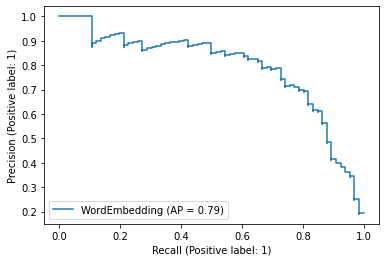

In [7]:
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_word,
    name="WordEmbedding",
)

## 文埋め込みを使う

In [8]:
from sklearn.base import TransformerMixin
import tensorflow_hub as hub
import numpy as np
import tensorflow_text

class UseVectorizer(TransformerMixin):
    def __init__(self):
        self._embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self._embed(X)

In [9]:
pipe_sent = Pipeline([
    ("vect", UseVectorizer()),
    ("clf", LogisticRegression(class_weight="balanced"))
])

pipe_sent.fit(train["text"], train["label_num"])

2022-05-27 01:43:24.189345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-27 01:43:24.190640: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-27 01:43:24.190694: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (47206f07dbfc): /proc/driver/nvidia/version does not exist
2022-05-27 01:43:24.201100: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-27 01:43:38.434733: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 274682880 exce

Pipeline(steps=[('vect', <__main__.UseVectorizer object at 0x7f1b44a69790>),
                ('clf', LogisticRegression(class_weight='balanced'))])

In [10]:
score_sent = pipe_sent.predict_proba(test["text"])[:,1]

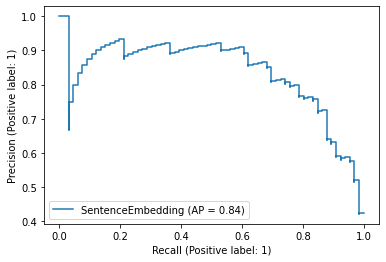

In [11]:
PrecisionRecallDisplay.from_predictions(
    y_true=test["label_num"],
    y_pred=score_sent,
    name="SentenceEmbedding",
)